In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm.notebook import trange

In [2]:
%matplotlib notebook

In [3]:
_ = plt.style.use('scientific')
_ = torch.manual_seed(7)

# Random Multi-Channel Spike Sequence

In [4]:
from rsnn.ss.rand import rand_ss

In [5]:
Tr = 20
alpha = 5
T = alpha * Tr
L = 250
p = 0.5

In [6]:
ss = rand_ss(L, alpha * Tr, Tr, p)

# Random Neural Network

In [7]:
K = 500

wb = 0.1
taub = 60
theta = 1.

beta = 2 # spreading hyperparameter
impulse_resp = lambda t_: (t_ >= 0) * t_ / beta * torch.exp(1 - t_ / beta)
impulse_resp_deriv = lambda t_: (t_ >= 0) * 1 / beta * (1 - t_ / beta) * torch.exp(1 - t_ / beta)

delays = torch.rand(L, K) * taub
sources = torch.randint(0, L, (L, K))
weights = torch.rand(L, K) * 2 * wb - wb

# Weights Optimization

In [8]:
from rsnn.optim.optim import optim
from rsnn.optim.utils import get_obs_mx
from rsnn.optim.nuv import box_prior

In [9]:
device = "cpu"

In [10]:
eps = 1 # firing surrounding window
b = 0.5 # maximum level in silent period
a = 0.5 # minimum slope in activity period

nuv = (
    lambda w_: box_prior(w_, -wb, wb, 10),
    lambda zf_: box_prior(zf_, theta, theta, 10),
    lambda za_: box_prior(za_, a, None, 5),
    lambda zs_: box_prior(zs_, None, b, 3)
)

err = (
    lambda w_: ((w_ - wb).abs() + (w_ + wb).abs() - 2 * wb).sum(),
    lambda zf_: (zf_ - theta).abs().sum(),
    lambda za_: ((za_ - a).abs() - (za_ - a)).sum(),
    lambda zs_: ((zs_ - b).abs() + (zs_ - b)).sum()
)

In [20]:
#for l in range(L):
for l in trange(L):
    #print(f"Neuron {l}: ", end="")
    C = get_obs_mx(l, ss, delays[l], sources[l], Tr, eps, impulse_resp, impulse_resp_deriv)
    weights[l] = optim(
        weights[l], 
        C, 
        nuv, 
        err, 
        max_iter=1000, 
        err_tol=1e-6, 
        return_err=False, 
        device=device
    )

  0%|          | 0/250 [00:00<?, ?it/s]

# Simulations

In [12]:
from rsnn.sim.sim import sim
from rsnn.sim.utils import compute_drift

Using /Users/haguettaz/Library/Caches/torch_extensions/py38_cpu as PyTorch extensions root...
Emitting ninja build file /Users/haguettaz/Library/Caches/torch_extensions/py38_cpu/sim_cpp/build.ninja...
Building extension module sim_cpp...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] c++ -MMD -MF sim.o.d -DTORCH_EXTENSION_NAME=sim_cpp -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_clang\" -DPYBIND11_STDLIB=\"_libcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1002\" -isystem /Users/haguettaz/opt/anaconda3/envs/rsnn/lib/python3.8/site-packages/torch/include -isystem /Users/haguettaz/opt/anaconda3/envs/rsnn/lib/python3.8/site-packages/torch/include/torch/csrc/api/include -isystem /Users/haguettaz/opt/anaconda3/envs/rsnn/lib/python3.8/site-packages/torch/include/TH -isystem /Users/haguettaz/opt/anaconda3/envs/rsnn/lib/python3.8/site-packages/torch/include/THC -isystem /Users/haguettaz/opt/anaconda3/envs/rsnn/include/python3.8 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++14 -c /Users/haguettaz/Documents/PhD/RSNN/src/rsnn/sim/sim.cpp -o sim.o 
[2/2] c++ sim.o -shared -L/Users/haguettaz/opt/anaconda3/envs/rsnn/lib/python3.8/site-packages/torch/lib -lc10 -ltorch_cpu -ltorch -ltorch_python -undefined dynamic_lookup -o sim_cpp.so
ld: warning: -undefined dynamic_lookup ma

Loading extension module sim_cpp...


In [13]:
sigma = 0 # init jitter
eta = 0 # continuous potential noise

In [14]:
ref_indices_f = [torch.argwhere(ss[l]).flatten() for l in range(L)]

In [15]:
sim_indices_f = sim(10Tr, ss, sources, delays, weights, Tr, beta, theta, wb, sigma, eta)

z = -0.532145 at t = 2 -> 22540
z = -0.477277 at t = 2.22541 -> 21733
z = -0.411044 at t = 2.44275 -> 20759
z = -0.302388 at t = 2.65035 -> 19160
z = -0.211652 at t = 2.84196 -> 17825
z = -0.129153 at t = 3.02022 -> 16612
z = -0.0439761 at t = 3.18635 -> 15358
z = 0.0285467 at t = 3.33994 -> 14292
z = 0.0742153 at t = 3.48287 -> 13620
z = 0.113867 at t = 3.61908 -> 13036
z = 0.16173 at t = 3.74945 -> 12332
z = 0.221652 at t = 3.87278 -> 11451
z = 0.295839 at t = 3.9873 -> 10359
z = 0.367028 at t = 4.0909 -> 9312
z = 0.436646 at t = 4.18403 -> 8288
z = 0.511327 at t = 4.26692 -> 7189
z = 0.571858 at t = 4.33882 -> 6298
z = 0.62403 at t = 4.40181 -> 5531
z = 0.670982 at t = 4.45713 -> 4840
z = 0.706252 at t = 4.50554 -> 4321
z = 0.735331 at t = 4.54876 -> 3893
z = 0.760189 at t = 4.5877 -> 3528
z = 0.782913 at t = 4.62299 -> 3193
z = 0.803124 at t = 4.65493 -> 2896
z = 0.820685 at t = 4.6839 -> 2638
z = 0.83609 at t = 4.71029 -> 2411
z = 0.850216 at t = 4.73441 -> 2203
z = 0.863352 at t 

In [16]:
drifts = torch.empty(L)
for l in range(L):
    drifts[l] = compute_drift(sim_indices_f[l], ref_indices_f[l])
drifts.mean() % T

tensor(nan)

### Visualisation

In [17]:
from rsnn.visualisation.visualisation import add_background

<IPython.core.display.Javascript object>


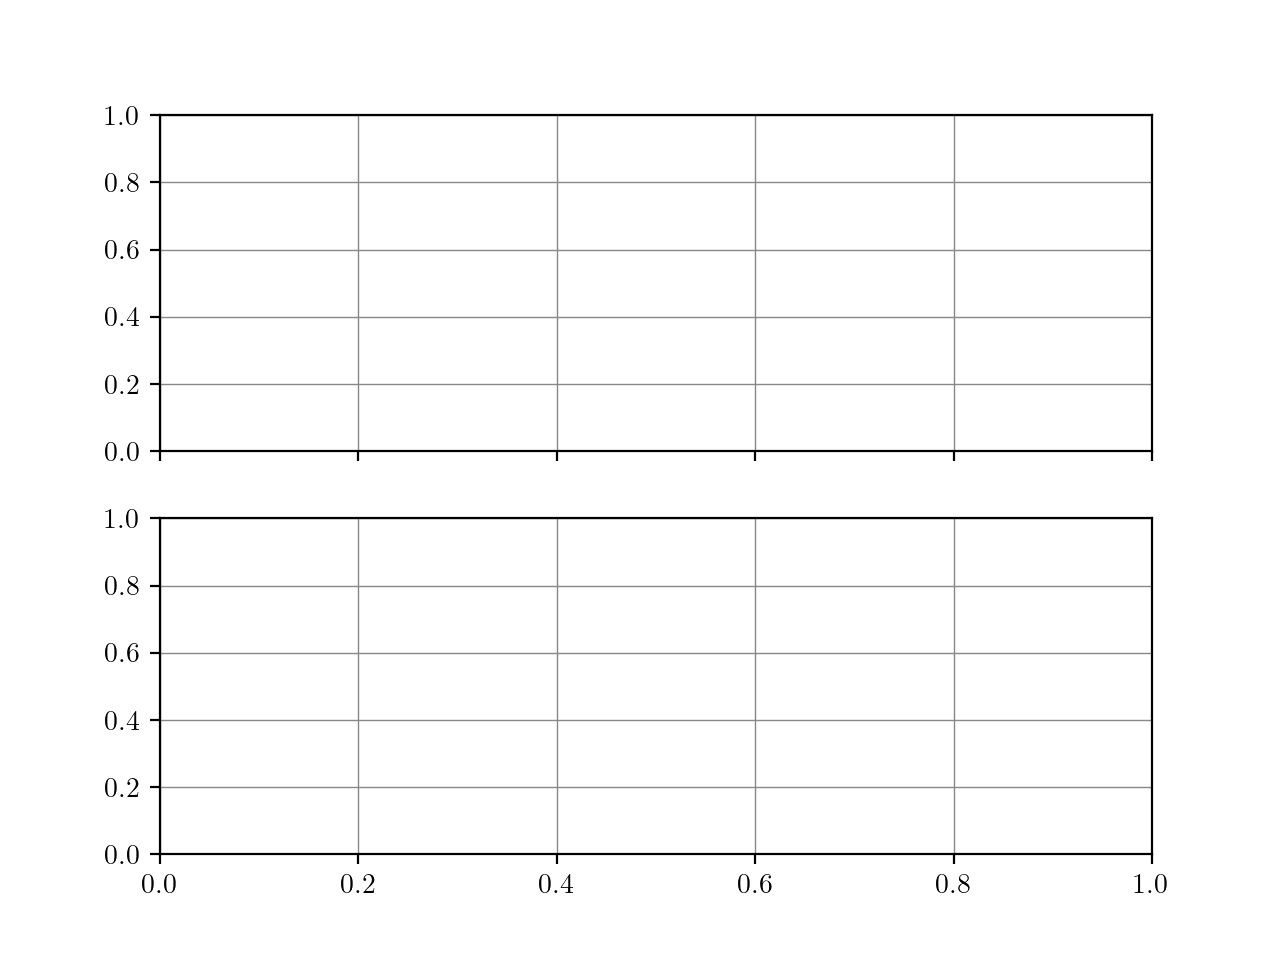

NameError: name 'spike_sequences' is not defined

In [18]:
fig, axes = plt.subplots(2, 1, sharex=True)

axes[0], handles = add_background(axes[0], torch.argwhere(spike_sequences[:, 42]).squeeze(), N, Nr, eps)
handles += axes[0].plot(mz[:, 42, 0], label="potential")
axes[0].set_yticks([b, theta])
axes[0].set_yticklabels(["$b$", r"$\theta$"])
axes[0].legend(handles=handles, loc="center left", bbox_to_anchor =(1, 0.5))

axes[1], handles = add_background(axes[1], torch.argwhere(spike_sequences[:, 42]).squeeze(), N, Nr, eps)
handles += axes[1].plot(mz[:, 42, 1], label="potential derivative")
axes[1].set_yticks([0, a])
axes[1].set_yticklabels([0, "$a$"])
axes[1].legend(handles=handles, loc="center left", bbox_to_anchor =(1, 0.5))

axes[0].set_xlim(0, T)
axes[0].set_xticks(np.linspace(0, T, 11))
axes[0].set_xticklabels(np.linspace(0, 1, 11).round(1))

fig.tight_layout()
fig.savefig("firing_template_matching.pdf", format="pdf", bbox_inches="tight")

# Matrix Analysis

In [ ]:
from rsnn.robustness.temporal_stability import compute_jitter_transition_matrices, compute_v0

In [ ]:
A = compute_jitter_transition_matrices(spike_sequences, weights, delays, sources, Tr, impulse_resp_deriv)

In [ ]:
Phi = torch.eye(A.size(1), A.size(2))
for n in range(N):
    Phi = A[n]@Phi

In [ ]:
eigvals = torch.linalg.eigvals(Phi)

In [ ]:
_ = plt.scatter(eigvals.real, eigvals.imag)
_ = plt.xlabel("$Re(z)$")
_ = plt.ylabel("$Im(z)$")

In [ ]:
values, _ = eigvals.abs().topk(5)
if values[1] < 1:
    v0 = compute_v0(Phi)
    indices = torch.arange(v0.size(0))
    colors = ["C3" if v0i > 0 else "C1" for v0i in v0 ]
    _ = plt.bar(indices, v0, color=colors)
else:
    print("not stable")

# Network Dynamics

In [ ]:
from rsnn.simulation.simulation import simulate
from rsnn.simulation.utils import get_input, compute_drift
from rsnn.visualisation.visualisation import add_spike_sequences

In [ ]:
references = [(torch.argwhere(spike_sequence).flatten()).tolist() for spike_sequence in torch.unbind(spike_sequences, -1)]

In [ ]:
firing_times = [[],[],[],[],[]] # init 5 simulations

In [ ]:
noisy_references = get_input(references, 0, 0, N)
firing_times[0] = simulate(sources, delays, mw, theta, Nr, impulse_resp, noisy_references, 10*N, 0.001)
compute_drift(firing_times[0], references, N, 9)

In [ ]:
noisy_references = get_input(references, 0, Tr, N)
firing_times[1] = simulate(sources, delays, mw, theta, Nr, impulse_resp, noisy_references, 10*N, 0.001)
compute_drift(firing_times[1], references, N, 9)

In [ ]:
noisy_references = get_input(references, 0, 2, N)
firing_times[2] = simulate(sources, delays, mw, theta, Nr, impulse_resp, noisy_references, 10*N, 0.001)
compute_drift(firing_times[2], references, N, 9)

In [ ]:
noisy_references = get_input(references, 0, 5, N)
firing_times[3] = simulate(sources, delays, mw, theta, Nr, impulse_resp, noisy_references, 10*N, 0.001)
compute_drift(firing_times[3], references, N, 9)

In [ ]:
noisy_references = get_input(references, 0, 10, N)
firing_times[4] = simulate(sources, delays, mw, theta, Nr, impulse_resp, noisy_references, 10*N, 0.001)
compute_drift(firing_times[4], references, N, 9)

In [ ]:
fig, axes = plt.subplots(5, 1, sharex=True)

for i in range(5):
    axes[i] = add_spike_sequences(axes[i], firing_times[i][42], N, 4*N, references[42])
    
fig.tight_layout()
fig.savefig("dynamics.pdf", format="pdf", bbox_inches="tight")